# Wikiart data cleanup:
## The images and metadata were downloaded using the amazing script from https://github.com/lucasdavid/wikiart, which was adapted to convert more data (artist name and title) in the final CSV file

### First, load the dataset (only metadata,  not the images)

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
data = pandas.read_csv('wikiart.csv', encoding='utf-8')
data.head()

/Users/lizbaldo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


contentId                                          title    artistName  \
0   337626.0                                  Bagged Rothko  Baxter& Iain   
1   337627.0                                       Lightbox  Baxter& Iain   
2   337630.0  Liquid Detergent, Vancouver, British Columbia  Baxter& Iain   
3   337632.0                                 Pneumatic Judd  Baxter& Iain   
4   337635.0                    Still Life with Six Colours  Baxter& Iain   

                                                url           style  \
0                                bagged-rothko-1965  Conceptual Art   
1                                     lightbox-1965  Conceptual Art   
2  liquid-detergent-vancouver-british-columbia-1965  Conceptual Art   
3                               pneumatic-judd-1965  Conceptual Art   
4                  still-life-with-six-colours-1965  Conceptual Art   

          genre artistContentId    artistUrl Unnamed: 8 Unnamed: 9 Unnamed: 10  
0      abstract          337468  iain-baxter        NaN        NaN         NaN  
1  installation          337468  iain-baxter        NaN        NaN         NaN  
2         photo          337468  iain-baxter        NaN        NaN         NaN  
3     sculpture          337468  iain-baxter        NaN        NaN         NaN  
4  installation          337468  iain-baxter        NaN        NaN         NaN

### Only keep what is necessary for the app / model and remove NANs

In [8]:
labels = data[['contentId','title','artistName','url', 'style','artistUrl']].copy()
labels=labels.dropna(subset=["style"])
# Only keep the 25 most prolific styles (enough data left for training)
style_count = labels['style'].value_counts()
Styles = style_count[0:25]
Styles

Impressionism                   13962
Realism                         12887
Romanticism                     10282
Expressionism                    8438
Post-Impressionism               7003
Surrealism                       5806
Art Nouveau (Modern)             5675
Baroque                          4785
Symbolism                        4248
Abstract Expressionism           3600
Naïve Art (Primitivism)          3112
Neoclassicism                    3065
Rococo                           2822
Northern Renaissance             2763
Cubism                           2041
Art Informel                     1739
Minimalism                       1728
Pop Art                          1537
Ukiyo-e                          1479
Abstract Art                     1461
Mannerism (Late Renaissance)     1414
High Renaissance                 1394
Early Renaissance                1386
Color Field Painting             1355
Magic Realism                    1166
Name: style, dtype: int64

### Remove parenthesis from labels (will cause trouble when calling descriptions later in the app)

In [9]:
labels=labels.replace({'Naïve Art (Primitivism)': 'Naïve Art'})
labels=labels.replace({'Art Nouveau (Modern)': 'Modern'})
labels=labels.replace({'Mannerism (Late Renaissance)': 'Late Renaissance'})
style_count = labels['style'].value_counts()
Styles = style_count[0:25]
Styles

Impressionism             13962
Realism                   12887
Romanticism               10282
Expressionism              8438
Post-Impressionism         7003
Surrealism                 5806
Modern                     5675
Baroque                    4785
Symbolism                  4248
Abstract Expressionism     3600
Naïve Art                  3112
Neoclassicism              3065
Rococo                     2822
Northern Renaissance       2763
Cubism                     2041
Art Informel               1739
Minimalism                 1728
Pop Art                    1537
Ukiyo-e                    1479
Abstract Art               1461
Late Renaissance           1414
High Renaissance           1394
Early Renaissance          1386
Color Field Painting       1355
Magic Realism              1166
Name: style, dtype: int64

### Visualize the data distribution

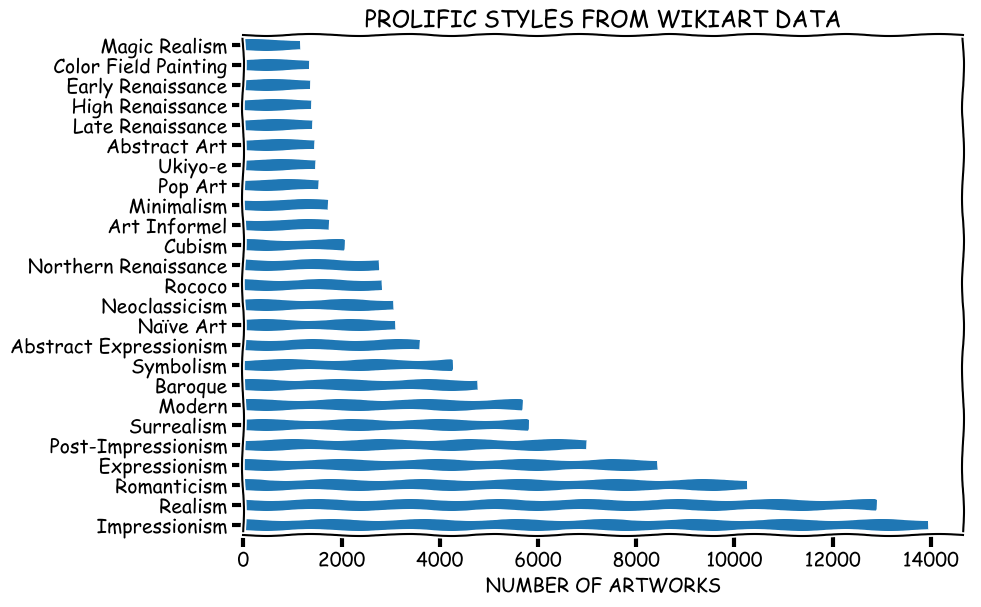

In [10]:
with plt.xkcd():
    fig = plt.figure(num=None, figsize=(8, 10), dpi=100, facecolor='w', edgecolor='k')
    ax = fig.add_axes((0.2, 0.9, 0.9, 0.5))
    Styles.plot(kind = "barh")
    plt.xlabel('NUMBER OF ARTWORKS')
    plt.title("PROLIFIC STYLES FROM WIKIART DATA")

    plt.show()
    fig.savefig('Wikiart_data_overview_25.pdf',bbox_inches='tight')


### Some urls were not found, leading to no data downloads: need to remove them

In [11]:
# Identify corrupted images:
import cv2
import os
# Drop rows not containing the above styles:
Styles = Styles.index
DATA = labels[labels['style'].isin(Styles)]
DATA['contentId']=DATA['contentId'].apply(str)
bad_images = []
for (i, filename) in enumerate(DATA.contentId):
    imagePath = '/Users/lizbaldo/Desktop/wikiart-master/wikiart/images/' + filename + '.jpg'
    # Verify if file exists:
    if os.path.exists(imagePath):
        image = cv2.imread(imagePath)
        try:
            cv2.resize(image, (128,128)).flatten()
        except:
            print('corrupted: ' + imagePath)    
            bad_images.append(filename)
    else:
        print('no path: ' + imagePath)    
        bad_images.append(filename)
        
    # show an update every 200 images until the last image
    if i > 0 and ((i + 1)% 200 == 0 or i ==len(DATA.contentId)-1):
        print("[INFO] processed {}/{}".format(i+1, len(DATA.contentId)))

images_to_remove = set(bad_images)
DATA = DATA[~DATA['contentId'].isin(images_to_remove)]

/Users/lizbaldo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362679.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362613.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362614.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362691.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362685.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362608.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362677.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362712.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362674.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362704.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362708.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362692.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/362701.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303751.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303752.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303753.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303754.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303755.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303756.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303757.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303758.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303759.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303761.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303763.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303764.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303765.0.jpg
no path: /Us

[INFO] processed 400/105148
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298001.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/297993.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298003.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298017.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/297997.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/297998.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298000.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298004.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298005.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298010.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298011.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/298014.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/imag

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196672.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196681.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196728.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196730.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196766.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196767.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196791.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196838.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196892.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196919.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196552.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196694.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/196704.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214516.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214627.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214469.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214495.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214526.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214536.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214573.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214577.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214608.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214510.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214615.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214632.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214503.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292905.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292894.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292892.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292900.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292893.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292901.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292902.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292889.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292906.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292890.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292904.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292067.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/292069.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188148.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188149.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188150.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188161.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188203.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188204.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188228.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188229.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188240.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188246.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188117.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188118.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/188120.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316266.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316270.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316263.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316232.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316235.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316239.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316240.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316245.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316250.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316251.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316261.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316262.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/316265.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325924.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325925.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325946.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325926.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325927.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325928.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325952.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/311854.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325930.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325936.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325931.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325932.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/325933.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260076.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260078.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260080.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260085.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260162.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260178.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260188.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260194.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260213.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260218.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260219.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260236.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260301.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260715.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260734.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260731.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260760.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260763.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260781.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260741.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260737.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260747.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260768.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260772.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260780.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/260801.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195453.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195454.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195456.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195467.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195473.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195309.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195311.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195327.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195328.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195329.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195346.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195389.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/195433.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/269788.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301652.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301642.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301649.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301657.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301653.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301643.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301658.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301654.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301655.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301647.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301656.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301651.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333650.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333651.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333633.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333636.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333623.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333635.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333645.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197156.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197169.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197192.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197343.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197112.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/197320.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319190.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319200.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319202.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319186.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319192.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319197.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319191.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319195.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319193.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319196.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319189.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319201.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/319206.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215604.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215627.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215637.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215646.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215657.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215679.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215696.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215697.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215698.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215716.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215766.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215832.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215852.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344605.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344608.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344609.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344613.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344614.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344620.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344621.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344622.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344623.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344624.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344627.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344628.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/344630.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363712.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363713.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363717.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363720.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363725.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363730.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363731.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363732.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363735.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363736.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363737.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363739.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363740.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191772.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191775.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191780.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191784.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191790.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191800.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191808.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191809.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191810.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191812.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191813.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191814.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191816.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221698.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221776.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221777.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221821.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/9.22337e+18.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221110.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/220790.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/220959.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221017.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221191.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221274.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221275.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/221388.0.jpg
no path: 

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289468.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289470.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289472.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289473.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289475.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289476.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289478.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289479.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289481.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289483.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289484.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289485.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289486.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243216.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243031.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243164.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243173.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243196.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243198.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243206.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243058.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243204.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243217.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243017.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243146.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243200.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201615.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201616.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201617.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201618.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201619.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201620.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201621.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201622.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201623.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201624.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201625.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201627.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201628.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200824.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200864.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200906.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200999.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201035.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201046.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201089.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201101.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201102.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201107.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/201171.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200637.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/200681.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191122.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191004.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191076.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191102.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191119.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191134.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191140.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191142.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191050.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191016.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191114.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191018.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/191072.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/290998.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291030.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291032.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291033.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291036.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291038.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291002.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291003.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291004.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291006.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291037.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/290990.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291001.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/231990.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/231999.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232146.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/231955.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232064.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232130.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232147.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232076.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232109.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232135.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232092.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/231949.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232063.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333732.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333709.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333710.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333724.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333711.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333712.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333725.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333727.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333728.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333713.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333714.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333716.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333717.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324899.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324905.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324908.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324909.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341986.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341990.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341991.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341996.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341998.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341992.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341997.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341989.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341987.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/296905.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295552.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295561.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/296708.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/296710.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/296903.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295533.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295556.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295558.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295565.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295549.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295532.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295539.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244334.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243880.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243900.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243983.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244049.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244102.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244188.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244236.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244279.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244310.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244352.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244387.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/243871.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329646.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329663.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329654.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329657.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329622.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329625.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329627.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329628.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329636.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329638.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329652.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329655.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/329661.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388381.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388382.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388383.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388384.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388385.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388386.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388387.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388362.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388363.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388364.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388365.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388366.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/388367.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249460.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291069.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291082.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291049.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291054.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291057.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291073.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291063.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291048.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291076.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291046.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291052.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/291058.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252073.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252078.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252079.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252080.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252085.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252087.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252088.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252090.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252092.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252093.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252095.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252096.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/252097.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263616.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263647.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263717.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263727.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263784.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263859.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263922.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263923.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263955.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264154.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264327.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263547.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/263578.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236053.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236073.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236085.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236099.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236121.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236150.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236154.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236168.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236174.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236210.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236212.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236042.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/236048.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324143.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324146.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324134.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324141.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324148.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324139.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324144.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324137.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324135.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324136.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324138.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324145.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/330521.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328093.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328129.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328147.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328164.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328182.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328194.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328779.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333616.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328894.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328890.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/328892.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333613.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/333614.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280198.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280199.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280200.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280203.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280204.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280210.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280214.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280215.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280216.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280220.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280223.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280227.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/280228.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/245192.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244901.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244873.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244964.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244967.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/245065.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/245131.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244914.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244915.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244977.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244841.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244872.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/244874.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322301.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322295.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322325.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322294.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322296.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322297.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322303.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322305.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322310.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322326.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322332.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322287.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/322288.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/9.22337e+18.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/9.22337e+18.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213907.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213931.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213969.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214011.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214153.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214174.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214187.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213929.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213970.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213990.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214031.0.jpg
no pat

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193246.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193247.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193250.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193251.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193252.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193254.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193269.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193272.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/303956.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193126.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193127.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193275.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/193157.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/212846.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/212853.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213026.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213060.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/213062.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211944.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/212148.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211736.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211737.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211744.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211790.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211880.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/211883.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249500.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249507.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249516.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249525.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249528.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249547.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249548.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249591.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249635.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249639.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249501.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249498.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/249627.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309170.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309175.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309159.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309166.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309151.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309153.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309174.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309158.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309173.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309180.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309181.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309182.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/309172.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275938.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275874.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275910.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275864.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275853.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275877.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275898.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275896.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275907.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275935.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275936.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275915.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/275918.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324719.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324734.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324722.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324732.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324730.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324711.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324720.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324724.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324728.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324709.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324708.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324731.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/324701.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/223809.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/223897.0.jpg
[INFO] processed 65400/105148
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/223999.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224105.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224108.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224114.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224123.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224297.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224298.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224469.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224590.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/224676.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/im

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262347.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262348.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262349.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262350.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262351.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262352.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262353.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262354.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262355.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262356.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262357.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262358.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/262359.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208575.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208580.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208581.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208590.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208604.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208650.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208682.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208684.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208727.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208731.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208764.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208780.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/208782.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248394.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248395.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248412.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248420.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248421.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248422.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248423.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248425.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248447.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248415.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248439.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248353.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/248380.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377903.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377906.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377904.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377909.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377910.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377917.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377911.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377912.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377916.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377915.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377920.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377918.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/377914.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219232.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219247.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219257.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219258.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219259.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219270.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219293.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219337.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219375.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219388.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/219502.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/218197.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/218361.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/214960.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215103.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215114.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215152.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215192.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215232.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215252.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215364.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215392.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215078.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215108.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215301.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/215307.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226665.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226666.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226744.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226746.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226751.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226791.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226839.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226840.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226852.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226877.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226962.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226963.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/226965.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332800.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332781.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332797.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332787.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332776.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332782.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332785.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332779.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332784.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332790.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332803.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/332788.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/274182.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313595.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313598.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313569.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313567.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313571.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313572.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313573.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313575.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313580.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313581.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313582.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313583.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/313584.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265857.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265863.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265882.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265898.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265919.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265920.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265954.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265997.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/265998.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/266002.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/266007.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/266021.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/266035.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232783.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232789.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232792.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232793.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232794.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232801.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232802.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232803.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232804.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232806.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232817.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232818.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/232825.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/315984.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/315993.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198484.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198440.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198468.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198475.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198598.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198523.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198458.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198464.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198477.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198482.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/198519.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238132.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238344.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238345.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238133.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238134.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238135.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238136.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238137.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238138.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238139.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238140.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238346.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/238141.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282610.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282611.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282612.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282613.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282614.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282616.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282617.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282619.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282620.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282621.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282622.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282623.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/282624.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336275.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336276.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336277.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336278.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336279.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336280.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336282.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336285.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336287.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336295.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336299.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336425.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/336463.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343156.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343187.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343205.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343165.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343183.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343153.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343154.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343155.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343166.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343181.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343182.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343196.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/343152.0.jpg
no path: /Us

[INFO] processed 90400/105148
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264518.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264521.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264523.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264526.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264464.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264515.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264525.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264509.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264497.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264459.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264466.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/264474.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/im

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242758.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242760.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242768.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242800.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242811.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242812.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242814.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242815.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242816.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242819.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242826.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242827.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/242831.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289720.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289739.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289748.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289679.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289703.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289712.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289725.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289743.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289749.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289682.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289724.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/289674.0.jpg
[INFO] processed 93200/105148
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/im

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233300.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233301.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233303.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233304.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233305.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233306.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233307.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233308.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233309.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233310.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233311.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233312.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/233313.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206912.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206915.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206916.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206917.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206974.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/206980.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207096.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207299.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207459.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207468.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207472.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207476.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207480.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207115.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207129.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207145.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207161.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207162.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207163.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207180.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207185.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207190.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207191.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207193.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207197.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/207204.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247266.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247284.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247239.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247253.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247256.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247258.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247308.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247310.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247263.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247319.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247278.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247286.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/247241.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295886.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295887.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295888.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295889.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295890.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295891.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295892.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/295893.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/276996.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/276983.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/276995.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/276977.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/276990.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340465.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340475.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340476.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340596.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340889.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/341170.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/363547.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/339452.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340466.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340691.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340692.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340722.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/340939.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287947.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287949.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287956.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287962.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287944.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287946.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287952.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287955.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287959.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287966.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287968.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287951.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/287954.0.jpg
no path: /Us

no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301284.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301281.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301242.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301243.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301272.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301274.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301278.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301279.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/301285.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/305575.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/305558.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/305567.0.jpg
no path: /Users/lizbaldo/Desktop/wikiart-master/wikiart/images/305574.0.jpg
no path: /Us

### Separate and move images from the download folder into training and validation folders

In [119]:
#Split data into 700 images for training and 300 images for testing for each class:
for (i,str_style) in enumerate(Styles):
    print(str_style)
    DATA_tmp = DATA[DATA['style'].isin([str_style])]
    training = DATA_tmp.sample(n=700)
    training['contentId'] = training['contentId'].apply(str)
    filename1 = training['contentId']
    for str_1 in filename1:
        try:
            os.rename('/Users/lizbaldo/Desktop/wikiart-master/wikiart/images/' + str_1 + '.jpg', '/Users/lizbaldo/Desktop/wikiart-master/wikiart/train/' + str_style + '/' + str_1 + '.jpg')
        except:
            print(str_1 + 'not found')
    DATA_tmp = DATA_tmp[~DATA_tmp['contentId'].isin(filename1)]
    testing = DATA_tmp.sample(n=300)
    filename2 = testing['contentId'].apply(str)
    for str_2 in filename2:
        try:
            os.rename('/Users/lizbaldo/Desktop/wikiart-master/wikiart/images/' + str_2 + '.jpg', '/Users/lizbaldo/Desktop/wikiart-master/wikiart/val/' + str_style + '/' + str_2 + '.jpg')
        except:
            print(str_2 + 'not found')
    # show an update every 10 images until the last image
    if i > 0 and ((i + 1)% 10 == 0 or i ==1000-1):
        print("[INFO] processed {}/{}".format(i+1, 1000))

Impressionism
Realism
Romanticism
187765not found
361777not found
201825not found
201598not found
360761not found
361133not found
273632not found
340569not found
196471not found
204296not found
339969not found
363175not found
269018not found
366669not found
291712not found
362400not found
196652not found
344348not found
366142not found
360632not found
276991not found
238683not found
294958not found
309747not found
347176not found
244867not found
254472not found
364979not found
332535not found
255933not found
209735not found
366693not found
Expressionism
Post-Impressionism
Surrealism
Art Nouveau (Modern)
Baroque
Symbolism
Abstract Expressionism
[INFO] processed 10/1000
Naive Art (Primitivism)
Neoclassicism
Rococo
Northern Renaissance
Cubism
Art Informel
Minimalism
Pop Art
Ukiyo-e
Abstract Art
[INFO] processed 20/1000
Mannerism (Late Renaissance)
Early Renaissance
High Renaissance
Color Field Painting
Magic Realism


### Clean up artists names

In [151]:
for (i,name) in enumerate(DATA['artistUrl']):
    if i > 0 and (i + 1)% 200 == 0:
        print("[INFO] processed {}".format(i+1))
    try:
        tmp1 = name.replace("-", " ")
        tmp2 = tmp1.title()
        DATA['artistName'].iloc[i] = tmp2
    except:
        print(name)
DATA.head()

/Users/lizbaldo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[INFO] processed 200
[INFO] processed 400
[INFO] processed 600
[INFO] processed 800
[INFO] processed 1000
[INFO] processed 1200
[INFO] processed 1400
[INFO] processed 1600
[INFO] processed 1800
[INFO] processed 2000
[INFO] processed 2200
[INFO] processed 2400
[INFO] processed 2600
[INFO] processed 2800
[INFO] processed 3000
[INFO] processed 3200
[INFO] processed 3400
[INFO] processed 3600
[INFO] processed 3800
[INFO] processed 4000
[INFO] processed 4200
[INFO] processed 4400
[INFO] processed 4600
[INFO] processed 4800
[INFO] processed 5000
[INFO] processed 5200
[INFO] processed 5400
[INFO] processed 5600
[INFO] processed 5800
[INFO] processed 6000
[INFO] processed 6200
[INFO] processed 6400
[INFO] processed 6600
[INFO] processed 6800
[INFO] processed 7000
[INFO] processed 7200
[INFO] processed 7400
[INFO] processed 7600
[INFO] processed 7800
[INFO] processed 8000
[INFO] processed 8200
[INFO] processed 8400
[INFO] processed 8600
[INFO] processed 8800
[INFO] processed 9000
[INFO] process

[INFO] processed 72000
[INFO] processed 72200
[INFO] processed 72400
[INFO] processed 72600
[INFO] processed 72800
[INFO] processed 73000
[INFO] processed 73200
[INFO] processed 73400
[INFO] processed 73600
[INFO] processed 73800
[INFO] processed 74000
[INFO] processed 74200
[INFO] processed 74400
[INFO] processed 74600
[INFO] processed 74800
[INFO] processed 75000
[INFO] processed 75200
[INFO] processed 75400
[INFO] processed 75600
[INFO] processed 75800
[INFO] processed 76000
[INFO] processed 76200
[INFO] processed 76400
[INFO] processed 76600
[INFO] processed 76800
[INFO] processed 77000
[INFO] processed 77200
[INFO] processed 77400
[INFO] processed 77600
[INFO] processed 77800
[INFO] processed 78000
[INFO] processed 78200
[INFO] processed 78400
[INFO] processed 78600
[INFO] processed 78800
[INFO] processed 79000
[INFO] processed 79200
[INFO] processed 79400
[INFO] processed 79600
[INFO] processed 79800
[INFO] processed 80000
[INFO] processed 80200
[INFO] processed 80400
[INFO] proc

Unnamed: 0  contentId  \
0           116030     286335   
1           136622     345948   
2           136623     345951   
3           136624     345890   
4           136626     345946   
5           136627     345949   
6            59990     189333   
7            59989     189332   
8            59988     189325   
9            42343     305948   
10           42339     305915   
11          136633     345910   
12           42328     305928   
13           42323     305935   
14           42318     305952   
15           42317     305951   
16           42316     305950   
17           42315     305949   
18           42314     305918   
19           42313     305917   
20           42312     305914   
21           42311     305913   
22           42309     305857   
23           42308     305856   
24           42307     305855   
25           42306     305924   
26           42305     305923   
27          136616     345950   
28          136615     345947   
29          136614     345945   
...            ...        ...   
104577      129559     240399   
104578      129560     240400   
104579       54272     193008   
104580       54273     192980   
104581       54274     193088   
104582       54275     306657   
104583      129556     240395   
104584      129526     240359   
104585      129547     240337   
104586      129545     239640   
104587      129528     240071   
104588      129529     240396   
104589      129530     239624   
104590      129531     240401   
104591      129532     240404   
104592      129533     240405   
104593      129534     240410   
104594      129535     239642   
104595      129546     240307   
104596      129536     239623   
104597      129538     239626   
104598      129539     239627   
104599      129540     239628   
104600      129541     239629   
104601      129542     239630   
104602      129543     239631   
104603      129544     239635   
104604       54302     193022   
104605      129537     239625   
104606      127389     329734   

                                                    title  \
0                                                Untitled   
1           Variation: Glorreicher Abend - Sommersegen II   
2                              Variation: ZÃ¤rtlichkeiten   
3                                            Autumn Sound   
4                                               Variation   
5                                Variation: Sonnenaufgang   
6                           Improvisation 31 (Sea Battle)   
7                              Improvisation 30 (Cannons)   
8                                  Improvisation (Dreamy)   
9                                              miristedup   
10                                                    Air   
11                                             Meditation   
12                          Drawing for Capturing the Air   
13                                                Grafe I   
14                                  Unstable Compositions   
15                                            Dialogue II   
16                                             Dialogue I   
17                                 Luminous Reflections I   
18                                       Energies (Study)   
19                                  Cheile Turzii (Study)   
20                                           Energy Field   
21                                       Unstable Balance   
22                                    The Growth of Trees   
23                                       Aquatic Movement   
24                                                   Rain   
25                                    Study (Field/Space)   
26                                              Landscape   
27                                  Variation: TrÃ¤umerei   
28                             Variation: Field of Tulips   
29                                              Variation   
...                                                   ...   
104577   

### Save into new csv file

In [152]:
data.to_csv('cleaned_wikiart_data.csv')